In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from random import seed
from random import random
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
df1 = pd.read_csv('sgemm_product.csv')

In [49]:
#Averaging the 4 run in last 4 column
df1['y']= (df1['Run1 (ms)']+df1['Run2 (ms)']+df1['Run3 (ms)']+df1['Run4 (ms)'])/4
df1.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1,inplace = True)
#df1 = df1.sample(frac = .2, random_state = 2)
df1.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.571953
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,368.750161
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.317500
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.667500
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.790000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.387500
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3341.507500


In [50]:
#min- max scaling
df = df1.copy(deep = True)
for col in df1.columns[0:14]:
    df[col] = ((df1[col]-df1[col].mean())/df1[col].max()-df1[col].min())

In [51]:
train, test = train_test_split(df,train_size=0.7, test_size=0.3, random_state=0)

In [52]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1] 

In [53]:
# linear regression function to predict y- hat
def y_pred(X,beta):
    y_hat = np.ones((X.shape[0],1))
    beta = beta.reshape(1,X.shape[1])
    for i in range(0,X.shape[0]):
        y_hat[i] = float(np.matmul(beta,X[i]))
    y_hat = y_hat.reshape(X.shape[0])
    return(y_hat)


In [54]:
# COST function
# y_hat and y have same shape; They are matrices;
def cost(y_hat, y):     
    m = len(y_hat)
    ct = (1/m) *0.5* sum(np.square(y_hat - y))
    return ct

In [80]:
def batch_gradient_desc(X,y,y_hat,beta,alpha,max_iter,n,threshold):
    it=0
    cost_list=[]
    rmse_list=[]
    for i in range(0,max_iter):
        it+=1
        #upgrade beta0 and betas1
        beta[0] = beta[0]-((alpha/X.shape[0])*(sum(y_hat-y)))
        for j in range(1,X.shape[1]):
            beta[j] = beta[j] - ((alpha/X.shape[0])*(sum((y_hat-y)*X.transpose()[j])))
        #call linear regression
        y_hat = y_pred(X,beta)
        #calculate the cost
        #cost= (1/X.shape[0]) * 0.5 * sum(np.square(y_hat-y))
        cost1 = cost(y_hat, y)
        rmse = np.sqrt(cost1)
        if len(cost_list)>1:
            if (cost1 < cost_list[-1] ): # if cost increases, we have gone past minimum. SO cut off
                if ((((cost_list[-1] - cost1)/cost_list[-1])*100) < threshold):
                    break
            else:    
                break       
        cost_list.append(cost1)
        rmse_list.append(rmse) 
        
    beta = beta.reshape(1,n+1)
    return(beta,cost_list,rmse_list,it)
            
            
    
    

In [91]:
def gradient_descent(X,y,alph,jj):
    max_iter = jj
    alpha = alph
    thresh = 0.001
    #calculate no of feature
    n = X.shape[1]
    #initialize the parameter vector beta
    beta = np.zeros(n+1)
    #concatenate 1 in X
    X_one = np.ones((X.shape[0],1))
    X = np.concatenate((X_one,X),axis = 1)
    #call y_pred function to get y hat
    y_hat = y_pred(X,beta)
    #call batch gradient descent 
    beta,cost,rmse,it = batch_gradient_desc(X,y,y_hat,beta,alpha,max_iter,n,thresh)
    return(beta,cost,rmse,it)


In [92]:

beta_train_final,cost_train,rmse_train,it_train = gradient_descent(X_train, y_train,0.001,100)
print(beta_train_final)
print(cost_train)
print(rmse_train)
print(it_train) 

[[ 3.14988828e-01 -6.60520779e-01 -1.07254864e+00 -4.89743144e+00
  -4.51227425e+00 -4.45268987e+00 -2.57118913e+00 -2.59106170e+00
  -1.51685007e-01  1.19569821e+00  9.87088901e-01 -2.39138224e-01
   4.03695012e-03  1.01182208e+00  1.17656159e+00]]
[68829.10225128633, 68802.37625385707, 68798.50057872434, 68794.64777782699, 68790.7957661749, 68786.94452221943, 68783.09404574563, 68779.2443365662, 68775.39539449291, 68771.54721934075, 68767.69981091347, 68763.85316903067, 68760.0072935004, 68756.16218413333, 68752.3178407433, 68748.47426314051, 68744.63145113921, 68740.78940455218, 68736.94812318508, 68733.10760685496, 68729.26785537525, 68725.42886855689, 68721.59064620819, 68717.7531881481, 68713.91649418478, 68710.08056412895, 68706.24539780106, 68702.41099500303, 68698.57735555424, 68694.7444792709, 68690.91236595312, 68687.08101542578, 68683.25042749711, 68679.42060197725, 68675.59153868508, 68671.76323743052, 68667.93569802481, 68664.10892028302, 68660.28290401958, 68656.45764904

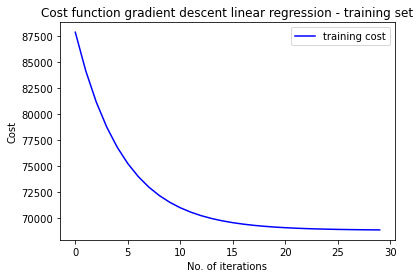

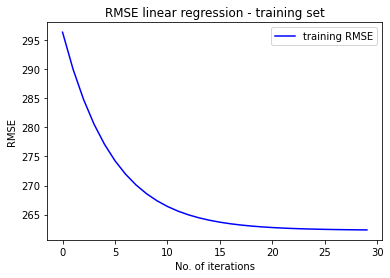

In [175]:
# plot Cost function training data set
plt.title("Cost function gradient descent linear regression - training set")
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_train,'b', label = 'training cost')
plt.legend()
plt.show()

# plot RMSE training data set
plt.title("RMSE linear regression - training set")
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.plot(rmse_train,'b', label = 'training RMSE')
plt.legend()
plt.show()


In [ ]:
## Linear Regression - Test set
# Using linear regression model function, we can obtain the test set model by passing the beta parameters and X_test
#test_X = X_test.to_numpy()
#test_Y = y_test.to_numpy()
#expt_itest_matrix = []
expt22_cost_matrix_test = {}
for i in range(500,4000,500):
    beta_train_final,cost_train,rmse_train,it_train=gradient_descent(X_train, y_train,0.001,i)
    c = cost_train[-1]
    X_one = np.ones((X_test.shape[0],1))
    X = np.concatenate((X_one,X_test),axis = 1)
    test_Y_hat = y_pred(X,beta_train_final)
    expt22_cost_matrix_test[i] = cost(test_Y_hat, y_test)
    
#error = cost(test_Y_hat, y_test)
print(expt22_cost_matrix_test)



In [138]:
def predict_test_cost(X,y,y_hat,beta,alpha,max_iter,n,threshold):
    it=0
    cost_list=[]
    rmse_list=[]
    for i in range(0,max_iter):
        it+=1
        #call linear regression
        y_hat = y_pred(X,beta)
        #calculate the cost
        #cost= (1/X.shape[0]) * 0.5 * sum(np.square(y_hat-y))
        cost1 = cost(y_hat, y)
        rmse = np.sqrt(cost1)
        if len(cost_list)>1:
            if (cost1 < cost_list[-1] ): # if cost increases, we have gone past minimum. SO cut off
                if (cost_list[-1] - cost1 < threshold):
                    break
            else:    
                break       
        cost_list.append(cost1)
        rmse_list.append(rmse) 
    return(cost_list,rmse_list,it)

# Experiment 1 linear reression for varrying value of alpha

In [139]:
## Experimentation
## Experiment - 1

## Experimentation
## Experiment - 1

# Linear Regression - for varying values of alpha; Fixed threshold at 0.00001 (Please see experiment 2 for the reason)
expt_train_cost_matrix = {}
expt_test_cost_matrix = {}
alph = [0.0001, 0.0003, 0.0005, 0.001, 0.005]
n = range(100,3000,500)
for i in alph:
    expt_itrain_matrix = []
    expt_itest_matrix = []
    for jj in n:
        beta_train_final,cost_train,rmse_train,it_train=gradient_descent(X_train, y_train,i,jj)
        c = cost_train[-1]
        expt_itrain_matrix.append([it_train,c])
        y_hat =  y_pred(X,beta_train_final)
        expt_itest_matrix.append([it_train,cost(y_hat, y_test)])
    expt_train_cost_matrix[i] = expt_itrain_matrix
    expt_test_cost_matrix[i] = expt_itest_matrix 
print(expt_test_cost_matrix)

{0.0001: [[100, 66772.1144319174], [600, 66586.73449241945], [1100, 66403.18427760008], [1600, 66221.4548104964], [2100, 66041.52387782813], [2600, 65863.36959887118]], 0.0003: [[100, 66697.74685132015], [600, 66149.26150747863], [1100, 65616.88620666756], [1600, 65100.04228316491], [2100, 64598.17639952352], [2600, 64110.75920654488]], 0.0005: [[100, 66623.66136746664], [600, 65722.09035424965], [1100, 64863.98931857919], [1600, 64046.81019686997], [2100, 63268.185607216496], [2600, 62525.9134354421]], 0.001: [[100, 66439.73178150567], [600, 64697.310293902716], [1100, 63116.8130144644], [1600, 61680.19380976864], [2100, 60371.797718901216], [2600, 59177.98450434844]], 0.005: [[3, 121973718.51763569], [3, 121973718.51763569], [3, 121973718.51763569], [3, 121973718.51763569], [3, 121973718.51763569], [3, 121973718.51763569]]}


In [140]:
x_11, y_11 = np.split(expt_train_cost_matrix[alph[0]],[-1],axis=1)
x_12, y_12 = np.split(expt_train_cost_matrix[alph[1]],[-1],axis=1)
x_13, y_13 = np.split(expt_train_cost_matrix[alph[2]],[-1],axis=1)
x_14, y_14 = np.split(expt_train_cost_matrix[alph[3]],[-1],axis=1)
x_15, y_15 = np.split(expt_train_cost_matrix[alph[4]],[-1],axis=1)

X_11, Y_11 = np.split(expt_test_cost_matrix[alph[0]],[-1],axis=1)
X_12, Y_12 = np.split(expt_test_cost_matrix[alph[1]],[-1],axis=1)
X_13, Y_13 = np.split(expt_test_cost_matrix[alph[2]],[-1],axis=1)
X_14, Y_14 = np.split(expt_test_cost_matrix[alph[3]],[-1],axis=1)
X_15, Y_15 = np.split(expt_test_cost_matrix[alph[4]],[-1],axis=1)

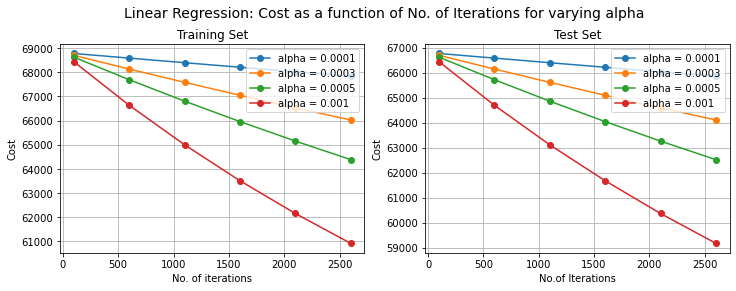

In [159]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(x_11, y_11, 'o-', label='alpha = 0.0001')
axes[0].plot(x_12, y_12, 'o-', label='alpha = 0.0003')
axes[0].plot(x_13, y_13, 'o-', label='alpha = 0.0005')
axes[0].plot(x_14, y_14, 'o-', label='alpha = 0.001')
#axes[0].plot(x_15, y_15,'o-', label='alpha = 0.005')
axes[0].set(xlabel='No. of iterations', ylabel='Cost',
       title='Training Set')
axes[0].grid()
axes[0].legend(loc="upper right")

axes[1].plot(X_11, Y_11, 'o-', label='alpha = 0.0001')
axes[1].plot(X_12, Y_12, 'o-', label='alpha = 0.0003')
axes[1].plot(X_13, Y_13, 'o-', label='alpha = 0.0005')
axes[1].plot(X_14, Y_14, 'o-', label='alpha = 0.001')
#axes[1].plot(X_15, Y_15, 'o-', label='alpha = 0.005')
axes[1].set(xlabel='No.of Iterations', ylabel='Cost',
       title='Test Set')
axes[1].grid()
axes[1].legend(loc="upper right")
figs.suptitle('Linear Regression: Cost as a function of No. of Iterations for varying alpha', fontsize=14)
figs.subplots_adjust(top=0.85)
#figs.savefig("expt1_linear.png")

In [16]:
def plot_alpha(train_X,train_y,test_X,test_y,max_iter,alpha,thresh):
    max_iter = max_iter
    alpha = alpha
    thresh = thresh
    #calculate no of feature
    n = train_X.shape[1]
    #initialize the parameter vector beta
    beta = np.zeros(n+1)
    #concatenate 1 in X
    X_one = np.ones((train_X.shape[0],1))
    X = np.concatenate((X_one,train_X),axis = 1)
    #call y_pred function to get y hat
    y_hat_train = y_pred(X,beta)
    #concatenate 1 in X
    X_one = np.ones((test_X.shape[0],1))
    X_test = np.concatenate((X_one,test_X),axis = 1)
    #call y_pred function to get y hat
    y_hat_test = y_pred(X_test,beta)
    #call batch gradient descent 
    beta_1,cost,rmse,it = batch_gradient_desc(X,train_y,y_hat_train,beta,alpha,max_iter,n,thresh)
    test_cost_1,test_rmse,test_it = predict_test_cost(X_test,test_y,y_hat_test,beta_1,alpha,max_iter,n,thresh)
    return(beta_1,cost,rmse,it,test_cost_1,test_rmse,test_it)
        

In [17]:
max_iter = 30
#alpha = 0.0001
thresh = 0.000001
 
beta_1,cost_1,rmse_1,it_1,test_cost_1,test_rmse_1,test_it_1 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0001,thresh)
#print(cost_1)
#print(it_1)
#print(test_cost_1)
#print(test_it_1)
beta_2,cost_2,rmse_2,it_2,test_cost_2,test_rmse_2,test_it_2 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0003,thresh)
#print(cost_2)
#print(it_2)
#print(test_cost_2)
#print(test_it_2)
beta_3,cost_3,rmse_3,it_3,test_cost_3,test_rmse_3,test_it_3 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0005,thresh)
#print(cost_3)
#print(it_3)
#print(test_cost_3)
#print(test_it_3)
beta_4,cost_4,rmse_4,it_4,test_cost_4,test_rmse_4,test_it_4 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.001,thresh)
#beta_5,cost_5,rmse_5,it_5,test_cost_5,test_rmse_5,test_it_5 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.005,thresh)

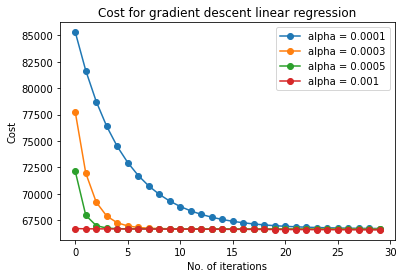

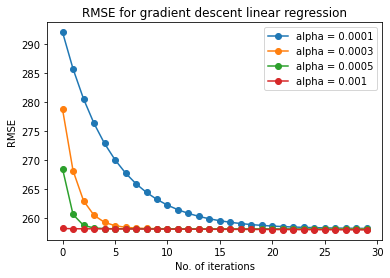

In [18]:
#Plot cost
plt.title("Cost for gradient descent linear regression")
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_1,'o-', label = 'alpha = 0.0001')
plt.plot(cost_2,'o-', label = 'alpha = 0.0003')
plt.plot(cost_3,'o-', label = 'alpha = 0.0005')
plt.plot(cost_4,'o-', label = 'alpha = 0.001')
#plt.plot(cost_5,'o-', label = 'alpha = 0.005')
#plt.plot(cost_list6, label = 'alpha = 0.0005')
#plt.plot(cost_list7, label = 'alpha = 0.0001')
plt.legend()
plt.show()

    
# plot RMSE
plt.title("RMSE for gradient descent linear regression")
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.plot(rmse_1,'o-', label = 'alpha = 0.0001')
plt.plot(rmse_2,'o-', label = 'alpha = 0.0003')
plt.plot(rmse_3,'o-', label = 'alpha = 0.0005')
plt.plot(rmse_4,'o-', label = 'alpha = 0.001')
#plt.plot(rmse_5,'o-', label = 'alpha = 0.005')
#plt.plot(rmse_list4, label = 'alpha = 0.003')
#plt.plot(rmse_list5, label = 'alpha = 0.001')
#plt.plot(rmse_list6, label = 'alpha = 0.0005')
#plt.plot(rmse_list7, label = 'alpha = 0.0001')

plt.legend()
plt.show()


#Experiment 2

In [19]:
# # varying alpha as well to show difference without overlap of curves. 
#calling plot alpha  function again
max_iter = 30
#alpha = 0.0001
#thresh = 0.000001
 
beta_1,cost_1,rmse_1,it_1,test_cost_1,test_rmse_1,test_it_1 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0001,0.01)
#print(cost_1)
#print(it_1)
#print(test_cost_1)
#print(test_it_1)
beta_2,cost_2,rmse_2,it_2,test_cost_2,test_rmse_2,test_it_2 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0003,0.1)
#print(cost_2)
#print(it_2)
#print(test_cost_2)
#print(test_it_2)
beta_3,cost_3,rmse_3,it_3,test_cost_3,test_rmse_3,test_it_3 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.0005,10)
#print(cost_3)
#print(it_3)
#print(test_cost_3)
#print(test_it_3)
beta_4,cost_4,rmse_4,it_4,test_cost_4,test_rmse_4,test_it_4 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.001,1000)
#beta_5,cost_5,rmse_5,it_5,test_cost_5,test_rmse_5,test_it_5 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,0.005,thresh)

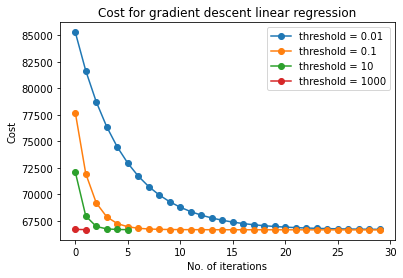

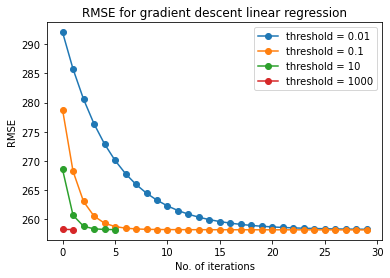

In [20]:
#Plot cost
plt.title("Cost for gradient descent linear regression")
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_1,'o-', label = 'threshold = 0.01')
plt.plot(cost_2,'o-', label = 'threshold = 0.1')
plt.plot(cost_3,'o-', label = 'threshold = 10')
plt.plot(cost_4,'o-', label = 'threshold = 1000')
#plt.plot(cost_5,'o-', label = 'alpha = 0.005')
#plt.plot(cost_list6, label = 'alpha = 0.0005')
#plt.plot(cost_list7, label = 'alpha = 0.0001')
plt.legend()
plt.show()

    
# plot RMSE
plt.title("RMSE for gradient descent linear regression")
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.plot(rmse_1,'o-', label = 'threshold = 0.01')
plt.plot(rmse_2,'o-', label = 'threshold = 0.1')
plt.plot(rmse_3,'o-', label = 'threshold = 10')
plt.plot(rmse_4,'o-', label = 'threshold = 1000')
#plt.plot(rmse_5,'o-', label = 'alpha = 0.005')
#plt.plot(rmse_list4, label = 'alpha = 0.003')
#plt.plot(rmse_list5, label = 'alpha = 0.001')
#plt.plot(rmse_list6, label = 'alpha = 0.0005')
#plt.plot(rmse_list7, label = 'alpha = 0.0001')

plt.legend()
plt.show()

In [21]:
## pick best threshold for train set- linear regression
#======================================================

max_iter = 10000
alpha = 0.0001

#start_time_7 = time.time()
beta_1,cost_1,rmse_1,it_1,test_cost_1,test_rmse_1,test_it_1 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,10000)
print("for threshold 10000")
print("Estimated train cost for is {0}".format(cost_1[-1]))
print("Estimated train RMSE is {0}".format(rmse_1[-1]))
print("Estimated test cost for is {0}".format(test_cost_1))
print("Estimated train RMSE is {0}".format(test_rmse_1))
#end_time_7 = time.time()

#start_time_8 = time.time()
beta_2,cost_2,rmse_2,it_2,test_cost_2,test_rmse_2,test_it_2 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,1000)
print("for threshold 1000")
print("Estimated train cost for is {0}".format(cost_2[-1]))
print("Estimated train RMSE is {0}".format(rmse_2[-1]))
print("Estimated test cost for is {0}".format(test_cost_2))
print("Estimated test RMSE is {0}".format(test_rmse_2))
#end_time_8 = time.time()

#start_time_9 = time.time()
beta_3,cost_3,rmse_3,it_3,test_cost_3,test_rmse_3,test_it_3 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,100)
print("for threshold 100")
print("Estimated train cost for is {0}".format(cost_3[-1]))
print("Estimated train RMSE is {0}".format(rmse_3[-1]))
print("Estimated test cost for is {0}".format(test_cost_3))
print("Estimated test RMSE is {0}".format(test_rmse_3))
#end_time_9 = time.time()

#start_time_10 = time.time()
beta_4,cost_4,rmse_4,it_4,test_cost_4,test_rmse_4,test_it_4 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,10)
print("for threshold 10")
print("Estimated train cost for is {0}".format(cost_4[-1]))
print("Estimated train RMSE is {0}".format(rmse_4[-1]))
print("Estimated test cost for is {0}".format(test_cost_4))
print("Estimated test RMSE is {0}".format(test_rmse_4))
#end_time_10 = time.time()

#start_time_11 = time.time()
beta_5,cost_5,rmse_5,it_5,test_cost_5,test_rmse_5,test_it_5 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,1)
print("for threshold 1")
print("Estimated train cost for is {0}".format(cost_5[-1]))
print("Estimated train RMSE is {0}".format(rmse_5[-1]))
print("Estimated test cost for is {0}".format(test_cost_5))
print("Estimated test RMSE is {0}".format(test_rmse_5))
#end_time_11 = time.time()

#start_time_12 = time.time()
beta_6,cost_6,rmse_6,it_6,test_cost_6,test_rmse_6,test_it_6 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.5)
print("for threshold 0.5")
print("Estimated train cost for is {0}".format(cost_6[-1]))
print("Estimated train RMSE is {0}".format(rmse_6[-1]))
print("Estimated test cost for is {0}".format(test_cost_6))
print("Estimated test RMSE is {0}".format(test_rmse_6))
#end_time_12 = time.time()

#start_time_12 = time.time()
beta_7,cost_7,rmse_7,it_7,test_cost_7,test_rmse_7,test_it_7 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.1)
print("for threshold 0.1")
print("Estimated train cost for is {0}".format(cost_7[-1]))
print("Estimated train RMSE is {0}".format(rmse_7[-1]))
print("Estimated test cost for is {0}".format(test_cost_7))
print("Estimated test RMSE is {0}".format(test_rmse_7))
#end_time_12 = time.time()

#start_time_13 = time.time()
beta_8,cost_8,rmse_8,it_8,test_cost_8,test_rmse_8,test_it_8 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.01)
print("for threshold 0.01")
print("Estimated train cost for is {0}".format(cost_8[-1]))
print("Estimated train RMSE is {0}".format(rmse_8[-1]))
print("Estimated test cost for is {0}".format(test_cost_8))
print("Estimated test RMSE is {0}".format(test_rmse_8))
#end_time_13 = time.time()

#start_time_14 = time.time()
beta_9,cost_9,rmse_1,it_9,test_cost_9,test_rmse_9,test_it_9 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.001)
print("for threshold 0.001")
print("Estimated train cost for is {0}".format(cost_9[-1]))
print("Estimated train RMSE is {0}".format(rmse_9[-1]))
print("Estimated test cost for is {0}".format(test_cost_9))
print("Estimated test RMSE is {0}".format(test_rmse_9))
#end_time_14 = time.time()

#start_time_15 = time.time()
beta_10,cost_10,rmse_10,it_10,test_cost_10,test_rmse_10,test_it_10 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.0001)
print("for threshold 0.0001")
print("Estimated train cost for is {0}".format(cost_10[-1]))
print("Estimated train RMSE is {0}".format(rmse_10[-1]))
print("Estimated test cost for is {0}".format(test_cost_10))
print("Estimated test RMSE is {0}".format(test_rmse_10))
#end_time_15 = time.time()

#start_time_16 = time.time()
beta_11,cost_11,rmse_11,it_11,test_cost_11,test_rmse_11,test_it_11 =plot_alpha(X_train,y_train,X_test,y_test,max_iter,alpha,0.00001)
print("for threshold 0.00001")
print("Estimated train cost for is {0}".format(cost_11[-1]))
print("Estimated train RMSE is {0}".format(rmse_11[-1]))
print("Estimated test cost for is {0}".format(test_cost_11))
print("Estimated test RMSE is {0}".format(test_rmse_11))
#end_time_16 = time.time()

# best threshold value 0.01

for threshold 10000
Estimated train cost for is 81659.97080104852
Estimated train RMSE is 285.76208776016546
Estimated test cost for is [86567.08083546952, 86567.08083546952]
Estimated train RMSE is [294.22284213750214, 294.22284213750214]
for threshold 1000
Estimated train cost for is 71725.32676372174
Estimated train RMSE is 267.8158448705411
Estimated test cost for is [78205.46575261396, 78205.46575261396]
Estimated test RMSE is [279.6524016571536, 279.6524016571536]
for threshold 100
Estimated train cost for is 67137.81778518728
Estimated train RMSE is 259.10966362756
Estimated test cost for is [74155.8561005304, 74155.8561005304]
Estimated test RMSE is [272.3157287057257, 272.3157287057257]
for threshold 10
Estimated train cost for is 66715.60223643784
Estimated train RMSE is 258.29363568705645
Estimated test cost for is [73706.65663074546, 73706.65663074546]
Estimated test RMSE is [271.48969894039345, 271.48969894039345]
for threshold 1
Estimated train cost for is 66672.256923256

NameError: name 'rmse_9' is not defined

In [46]:
# Experiment 3 selecting 8 random features
df.head(4)
df2 = df.iloc[:,:-1]
df2.head(4)
df2  =df2.sample(8, axis=1,random_state = 0)
df2.head()
df2 = pd.concat([df2, df['y']], axis=1)


In [47]:
train2, test2 = train_test_split(df2,train_size=0.7, test_size=0.3, random_state=0)
X_train_2 = train2.iloc[:,:-1]
y_train_2 = train2.iloc[:,-1]
X_test_2 = test2.iloc[:,:-1]
y_test_2 = test2.iloc[:,-1] 


In [55]:
# comparing the cost between full model and 8 randomly selected features
beta_train_final_1,cost_train_1,rmse_train_1,it_train_1 = gradient_descent(X_train, y_train,0.001,30)
beta_train_final_2,cost_train_2,rmse_train_2,it_train_2 = gradient_descent(X_train_2, y_train_2,0.001,30)
cost_train_1_val = cost_train_1[-1]
cost_train_2_val = cost_train_2[-1]

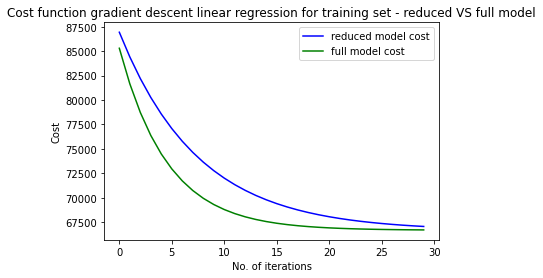

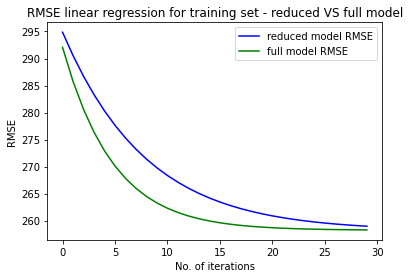

In [56]:
# plot Cost function
plt.title("Cost function gradient descent linear regression for training set - reduced VS full model")
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_train_2,'b', label = 'reduced model cost')
plt.plot(cost_train_1,'g', label = 'full model cost')
plt.legend()
plt.show()

# plot RMSE
plt.title("RMSE linear regression for training set - reduced VS full model")
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.plot(rmse_train_2,'b', label = 'reduced model RMSE')
plt.plot(rmse_train_1,'g', label = 'full model RMSE')
plt.legend()
plt.show()


In [62]:
# calculating the cost for test set
X_one = np.ones((X_test_2.shape[0],1))
X = np.concatenate((X_one,X_test_2),axis = 1)
test_Y_hat = y_pred(X,beta_train_final_2)
expt_itest_matrix_8f = cost(test_Y_hat, y_test_2)
#error = cost(test_Y_hat, y_test)
print(expt_itest_matrix_8f)

74181.62973987611


(0.0, 1.0, 0.0, 1.0)

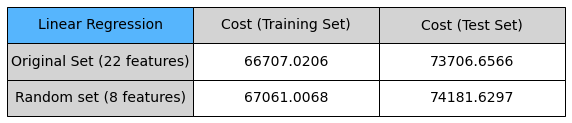

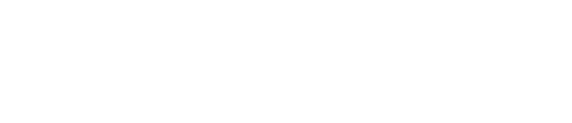

In [63]:
fig3 = plt.figure(figsize=(10, 2))
ax3 = plt.subplot(111)
ax3.axis('off')

colLabels3 = ['Linear Regression','Cost (Training Set)', 'Cost (Test Set)']
cellText3 = [['Original Set (14 features)',round(cost_train_1_val,4), round(expt_itest_matrix,4)],
            ['Random set (8 features)',round(cost_train_2_val,4), round(expt_itest_matrix_8f,4)]]
colColours3 = ['#56b5fd','lightgray','lightgray']
rowColours3 = [['lightgray','w','w'],['lightgray','w','w']]
tab3 = ax3.table(cellText=cellText3, colLabels=colLabels3, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours3, colColours=colColours3)
tab3.auto_set_font_size(False)
tab3.set_fontsize(14)

fig33 = plt.figure(figsize=(10, 2))
ax33 = plt.subplot(111)
ax33.axis('off')

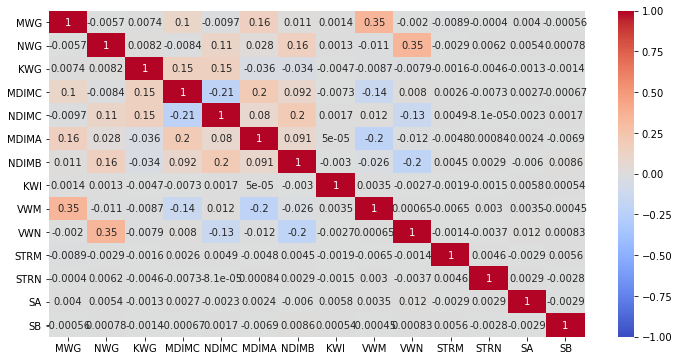

In [66]:
# Experiment 4 
#selecting the features based on the correlation between the features
df_new = df.iloc[:,:-1].copy()
#df_new.head(4)
plt.figure(figsize=(12,6))

sns.heatmap(df_new.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [80]:
df.head(4)
df_corr = df.iloc[:,:-1]
df_corr = df_corr.drop(df_corr[['VWM','VWN','NWG','MDIMC','KWG','NDIMC']], axis=1)
#df_corr.head(4)
df_corr = pd.concat([df_corr, df['y']], axis=1)
df_corr.head(4)

,MWG,MDIMA,NDIMB,KWI,STRM,STRN,SA,SB,y
100290,-16.127243,-8.043139,-8.292819,-1.624783,-0.497786,-0.496896,0.499565,-0.501511,28.165
47337,-16.377243,-8.293139,-8.042819,-1.624783,0.502214,-0.496896,-0.500435,0.498489,202.715
149450,-15.627243,-8.043139,-8.042819,-2.374783,0.502214,-0.496896,0.499565,-0.501511,67.365
15785,-16.502243,-8.293139,-8.042819,-2.374783,0.502214,-0.496896,-0.500435,0.498489,103.890


In [81]:
train3, test3 = train_test_split(df_corr,train_size=0.7, test_size=0.3, random_state=0)
X_train_3 = train3.iloc[:,:-1]
y_train_3 = train3.iloc[:,-1]
X_test_3 = test3.iloc[:,:-1]
y_test_3 = test3.iloc[:,-1] 

In [82]:
beta_train_final_3,cost_train_3,rmse_train_3,it_train_3 = gradient_descent(X_train_3, y_train_3,0.001,30)
cost_train_3_val = cost_train_3[-1]

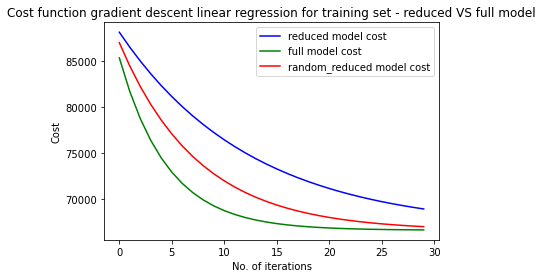

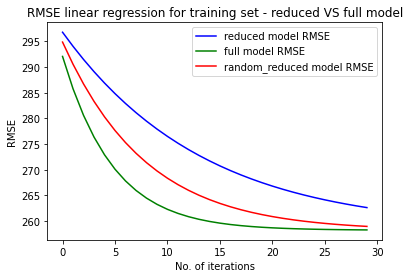

In [83]:
# plot Cost function
plt.title("Cost function gradient descent linear regression for training set - reduced VS full model")
plt.xlabel("No. of iterations")
plt.ylabel("Cost")
plt.plot(cost_train_3,'b', label = 'reduced model cost')
plt.plot(cost_train_1,'g', label = 'full model cost')
plt.plot(cost_train_2,'r', label = 'random_reduced model cost')
plt.legend()
plt.show()

# plot RMSE
plt.title("RMSE linear regression for training set - reduced VS full model")
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.plot(rmse_train_3,'b', label = 'reduced model RMSE')
plt.plot(rmse_train_1,'g', label = 'full model RMSE')
plt.plot(rmse_train_2,'r', label = 'random_reduced model RMSE')
plt.legend()
plt.show()

In [84]:
# calculating the cost for test set
X_one = np.ones((X_test_2.shape[0],1))
X = np.concatenate((X_one,X_test_3),axis = 1)
test_Y_hat = y_pred(X,beta_train_final_3)
expt_itest_matrix_8f_corr = cost(test_Y_hat, y_test_3)
#error = cost(test_Y_hat, y_test)
print(expt_itest_matrix_8f_corr)

76305.68567510632


(0.0, 1.0, 0.0, 1.0)

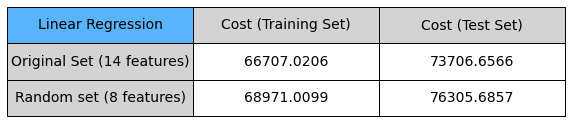

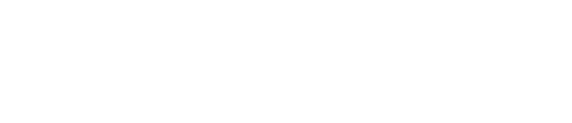

In [85]:
fig3 = plt.figure(figsize=(10, 2))
ax3 = plt.subplot(111)
ax3.axis('off')

colLabels3 = ['Linear Regression','Cost (Training Set)', 'Cost (Test Set)']
cellText3 = [['Original Set (14 features)',round(cost_train_1_val,4), round(expt_itest_matrix,4)],
            ['Random set (8 features)',round(cost_train_3_val,4), round(expt_itest_matrix_8f_corr,4)]]
colColours3 = ['#56b5fd','lightgray','lightgray']
rowColours3 = [['lightgray','w','w'],['lightgray','w','w']]
tab3 = ax3.table(cellText=cellText3, colLabels=colLabels3, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours3, colColours=colColours3)
tab3.auto_set_font_size(False)
tab3.set_fontsize(14)

fig33 = plt.figure(figsize=(10, 2))
ax33 = plt.subplot(111)
ax33.axis('off')